## Inicializacja Wag Sieci Neuronowej

### Importy

In [1]:
# Instalcaja Keras
!pip install -q keras
import keras

# Instalacja biblioteki do rysowania tablic
!pip install -q tabulate
import tabulate

# Ogólne
import os
import numpy as np
import random as rn
from scipy.stats import truncnorm
from IPython.display import HTML, display

# Keras & Tensorflow
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.initializers import (
    Zeros, 
    Ones, 
    RandomUniform, 
    RandomNormal, 
    TruncatedNormal, 
    glorot_uniform
)

# Wizualizacja
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

# Kontrola Losowości - ma na celu przybliżyć rezultaty tego notatnika na każdym komputerze
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 3939
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)

tf.set_random_seed(RANDOM_SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

Using TensorFlow backend.


### Wczytanie zestawu danych MNIST

MNIST to dość stary zbiór danych skompletowany pod koniec lat dziewięćdziesiątych przez Yana LeCuna na potrzeby testowania algorytmów uczenia maszynowego. Jest on wciąż dziś powszechnie używany w celach edukacyjnych ze względu na nie duży poziom trudności oraz duża ilość wniosków jaką można z niego wyciągnąć.

Oficjalny link do zbioru danych: http://yann.lecun.com/exdb/mnist/

Zbiór składa się z 60000 obrazów będących danymi do uczenia oraz 10000 obrazów testowych. Obrazy są jednokanałowe - czyli czarno białe. Rozmiar każdego obrazu to 28x28 pikseli. Obrazy przedstawiają ręcznie pisane cyfry - od 0 do 9.

MNIST jest na tyle popularny, że najczęsciej używane frameworki takie jak **TensorFlow** czy **Keras** zawierają moduły, które pozwalają na szybkie jego wczytanie:

Wizualizacja: 


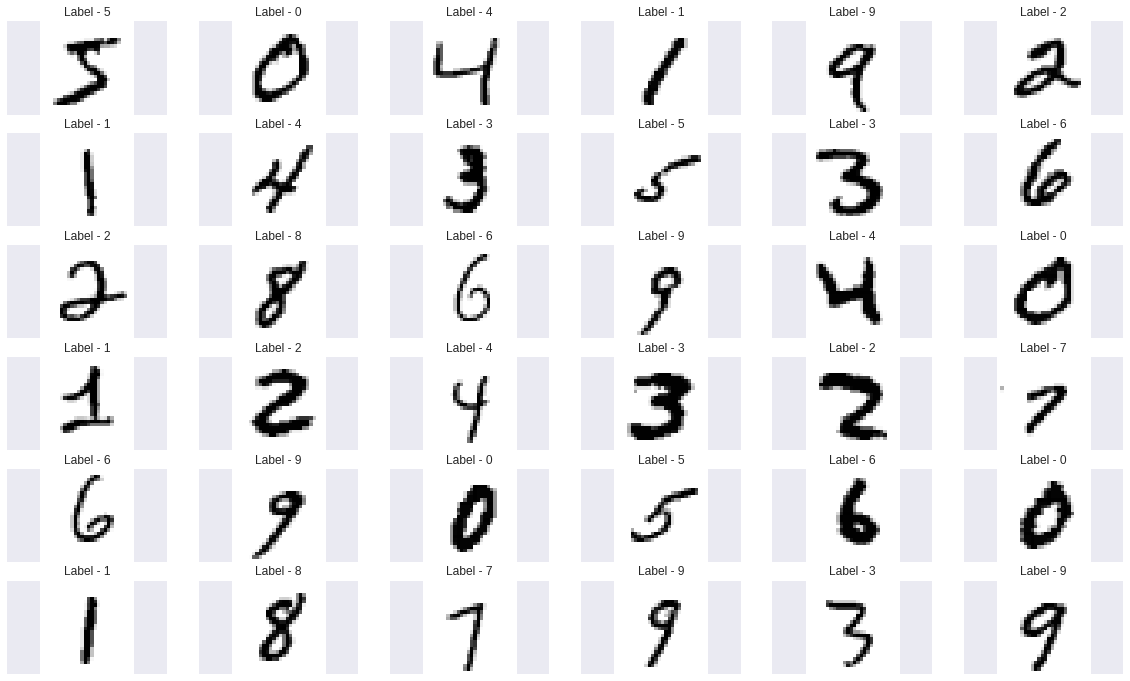

In [2]:
from keras.datasets import mnist

# Wczytanie danych do tablic (60000x28x28), (60000x1), (10000x28x28), (10000x1)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

def show_digits(X_train, y_train, rows_num=6):
    """Funkcja która dokonuje wizualizacji zdjęć MNIST w wierszach.
    Parametry:
        X_train - tablica ze zdjęciami, format (ILOŚĆ ZDJĘĆ x SZEROKOŚĆ x WYSOKOŚĆ)
        y_train - tablica z etykietami do zdjęć, format (ILOŚĆ ZDJĘĆ x 1 lub ILOŚĆ ZDJĘĆ,)
        rows_num - ilość wierszy do pokzania
    """
    
    # Stworzenie dwóch wierszy wykresów
    figure, axes = plt.subplots(nrows=rows_num, ncols=6, sharex=True, sharey=True, figsize=(20, rows_num * 2))
    
    # Dla każdego indeksu wiersza
    for row_index in range(rows_num):
        
        # Wybierz wiersz wykresów, obrazy do pokazania, opisy do obrazów
        ax_row = axes[row_index]
        images = X_train[(row_index*8):(row_index+1)*8]
        labels = y_train[(row_index*8):(row_index+1)*8]
        
        # Wypełnij wiersz obrazami i tekstem
        for ax, img, label in zip(ax_row, images, labels):
            ax.imshow(img, cmap='gray_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title("Label - {}".format(label))
            
print("Wizualizacja: ")
show_digits(X_train, y_train)

### Przygotowanie danych przed podaniem do sieci neuronowej 

- Rozwinięcie macierzy obrazu do wektora

In [3]:
print("Zbior do uczenia - przed rozwinieciem: ")
print(" - rozmiar: {}".format(X_train.shape))
print(" - etykieta: {}".format(y_train.shape))
print("Zbior do testow - przed rozwinieciem: ")
print(" - rozmiar: {}".format(X_test.shape))
print(" - etykieta: {}".format(y_test.shape))

# Rozbicie zdjęc 28x28 do wektora 784
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

print("\nZbior do uczenia - po rozwinieciu: ")
print(" - rozmiar: {}".format(X_train.shape))
print(" - etykieta: {}".format(y_train.shape))
print("Zbior do testow - po rozwinieciu: ")
print(" - rozmiar: {}".format(X_test.shape))
print(" - etykieta: {}".format(y_test.shape))

Zbior do uczenia - przed rozwinieciem: 
 - rozmiar: (60000, 28, 28)
 - etykieta: (60000,)
Zbior do testow - przed rozwinieciem: 
 - rozmiar: (10000, 28, 28)
 - etykieta: (10000,)

Zbior do uczenia - po rozwinieciu: 
 - rozmiar: (60000, 784)
 - etykieta: (60000,)
Zbior do testow - po rozwinieciu: 
 - rozmiar: (10000, 784)
 - etykieta: (10000,)


- Normalizacja

In [4]:
print("Zbior do uczenia - przed normalizacją: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Zbior do testow - przed normalizacją: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

# Zrzutowanie uint8 do float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Sprwadzenie zasięgu wartości pikseli do przedziału <0, 1>
X_train /= 255
X_test /= 255

print("\nZbior do uczenia - po normalizacji: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Zbior do testow - po normalizacji: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

Zbior do uczenia - przed normalizacją: 
 - min: 0
 - max: 255
Zbior do testow - przed normalizacją: 
 - min: 0
 - max: 255

Zbior do uczenia - po normalizacji: 
 - min: 0.0
 - max: 1.0
Zbior do testow - po normalizacji: 
 - min: 0.0
 - max: 1.0


- One-Hot-Encoding etykiet

In [5]:
print("Etykiesty danych do uczenia - przed OHE: ")
print(" - przykład etykiet: {}".format(y_train[:10]))
print("Etykiesty danych do testu - przed OHE: ")
print(" - przykład etykiet: {}".format(y_test[:10]))

# One-Hot-Encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print("Etykiesty danych do uczenia - przed OHE: ")
print(" - przykład etykiet: \n{}".format(y_train[:10]))
print("Etykiesty danych do testu - przed OHE: ")
print(" - przykład etykiet: \n{}".format(y_test[:10]))

Etykiesty danych do uczenia - przed OHE: 
 - przykład etykiet: [5 0 4 1 9 2 1 3 1 4]
Etykiesty danych do testu - przed OHE: 
 - przykład etykiet: [7 2 1 0 4 1 4 9 5 9]
Etykiesty danych do uczenia - przed OHE: 
 - przykład etykiet: 
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Etykiesty danych do testu - przed OHE: 
 - przykład etykiet: 
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Podział na zbiór trenujący i walidujący

In [6]:
split_ratio = 0.8
split_index = int(X_train.shape[0] * split_ratio)

X_train_input, y_train_input = X_train[:split_index], y_train[:split_index]
X_val_input, y_val_input = X_train[split_index:], y_train[split_index:]

print("X_train_input shape: {}".format(X_train_input.shape))
print("y_train_input shape: {}".format(y_train_input.shape))
print("X_val_input shape: {}".format(X_val_input.shape))
print("y_val_input shape: {}".format(y_val_input.shape))

X_train_input shape: (48000, 784)
y_train_input shape: (48000, 10)
X_val_input shape: (12000, 784)
y_val_input shape: (12000, 10)


### Funkcje pomocnicze

In [0]:
def build_and_train_model(X_train, y_train, X_val, y_val, batch_size=128, 
                          epochs=3, activation="relu", initializer=None):
  
    # Wyciągnięcie wielkości pierwszej warstwy z wektora wartości wejściowych
    input_units = X_train[0].shape[0]
    
    # Wyciągnięcie ilości klas z kształtu wektora wartości docelowych
    num_classes = y_train[0].shape[0]
    
    # Zadeklarowanie struktury modelu
    model = Sequential()
    model.add(Dense(256, 
                    activation=activation, 
                    input_shape=(input_units,), 
                    kernel_initializer=initializer))
    model.add(Dense(128, 
                    activation=activation, 
                    kernel_initializer=initializer))
    model.add(Dense(64, 
                    activation=activation, 
                    kernel_initializer=initializer))
    model.add(Dense(num_classes, 
                    activation="softmax",
                    kernel_initializer=initializer))
    
    # Stworzenie modelu, wybranie funkcji kosztu, optymizera oraz metryki
    model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
    
    # Trenowanie sieci
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(X_val, y_val))
    
    # Result
    score = model.evaluate(X_val, y_val, verbose=0)
    
    return model, history, score

### Inicializacja wag zerami oraz jedynkami

In [0]:
# Inicializacja zerami
model0 ,history0, score0 = build_and_train_model(
    X_train_input, y_train_input, X_val_input, y_val_input, initializer=Zeros())

# Inicializacja jedynkami
model1, history1, score1 = build_and_train_model(
    X_train_input, y_train_input, X_val_input, y_val_input, initializer=Ones())

Inicializacja wag: same zera:
 - error: 2.3020913976
 - acc: 0.106

Inicializacja wag: same jedynki:
 - error: 14.4498723755
 - acc: 0.1035


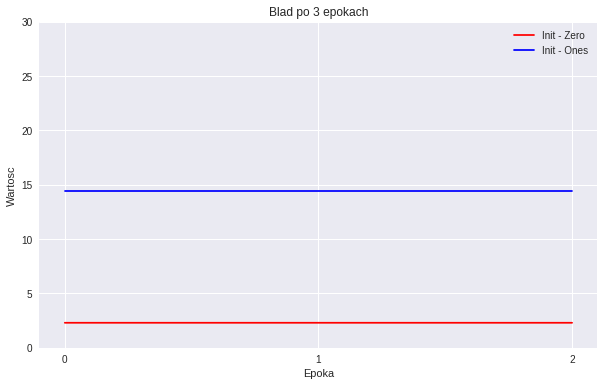

In [9]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(history0.history["val_loss"], c="r")
ax.plot(history1.history["val_loss"], c="b")
ax.set_title("Blad po 3 epokach")
ax.set_ylabel("Wartosc")
ax.set_xlabel("Epoka")
ax.set_ylim(0, 30)
ax.set_xticks([0, 1, 2])
ax.legend(["Init - Zero", "Init - Ones"], loc="best");
    
test_score0, test_accuracy0 = score0
print("Inicializacja wag: same zera:")
print(" - error: {}".format(test_score0))
print(" - acc: {}".format(test_accuracy0))

test_score1, test_accuracy1 = score1
print("\nInicializacja wag: same jedynki:")
print(" - error: {}".format(test_score1))
print(" - acc: {}".format(test_accuracy1))

Jak widać w obu przypadkach sieć się nie uczy. W obu przypadkach **accuracy** to około 10%. Wynika to z tego, że sieć nie wie, które wagi powinna zmieniać gdyż wynik na wyjściu z sieci jest zawsze taki sam. 

#### Wniosek:
Wagi sieci neuronowej nie powinny być inicializowowane takimi samymi wartościami. Wartości powinny być różne.

### Rozkład Jednostajny Ciągły (RandomUniform)

Rozkład jednostajny ciągły to taki rozkład, w którym mamy taką samą szansę wylosowania każdej wartości. Prezentuje się on następująco:

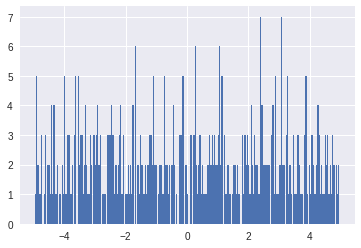

In [10]:
space0 = np.random.uniform(low=-5.0, high=5.0, size=500)
n0, bins0, patches0 = plt.hist(space0, bins=250);

Jeżeli mamy 500 wartości i spróbujemy je rozłożyć pomiędzy 250 słupków histogramu, to jako, że prawdopodobieństwo na wylosowanie każdej liczby jest równe, to w każdym słupku powinniśmy mieć średnio 2 wartości. Co można sprawdzić:

In [11]:
print("Srednia ilosc wartosci na slupek histogramu: {}".format(np.mean(n0)))

Srednia ilosc wartosci na slupek histogramu: 2.0


Przetestujmy zakresy: niesymetryczny [0.0, 1.0) oraz symetryczny [-1.0, 1.0).

In [0]:
# [0.0, 1.0)
model2, history2, score2 = build_and_train_model(
    X_train_input, y_train_input, X_val_input, y_val_input, initializer=RandomUniform(minval=0.0, maxval=1.0, seed=RANDOM_SEED))

# [-1.0, 1.0)
model3, history3, score3 = build_and_train_model(
    X_train_input, y_train_input, X_val_input, y_val_input, initializer=RandomUniform(minval=-1.0, maxval=1.0, seed=RANDOM_SEED))

Inicializacja wag: [0.0, 1.0):
 - error: 14.4095770874
 - acc: 0.106

Inicializacja wag: [-1.0, 1.0):
 - error: 7.07048876381
 - acc: 0.560583333333


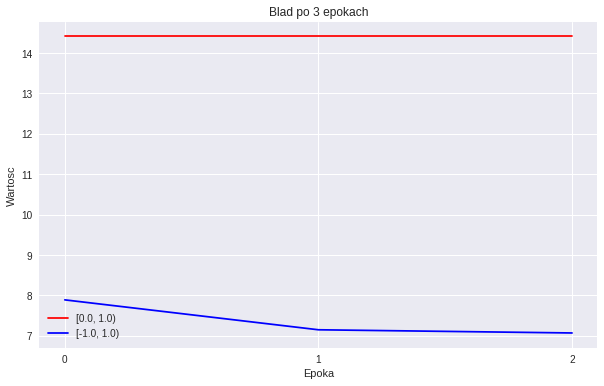

In [13]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(history2.history["val_loss"], c="r")
ax.plot(history3.history["val_loss"], c="b")
ax.set_title("Blad po 3 epokach")
ax.set_ylabel("Wartosc")
ax.set_xlabel("Epoka")
ax.set_xticks([0, 1, 2])
ax.legend(["[0.0, 1.0)", "[-1.0, 1.0)"], loc="best");
    
test_score2, test_accuracy2 = score2
print("Inicializacja wag: [0.0, 1.0):")
print(" - error: {}".format(test_score2))
print(" - acc: {}".format(test_accuracy2))

test_score3, test_accuracy3 = score3
print("\nInicializacja wag: [-1.0, 1.0):")
print(" - error: {}".format(test_score3))
print(" - acc: {}".format(test_accuracy3))

Sieć neuronowa lepiej sobie poradziła kiedy wagi były symetryczne. W przypadku gdy zakres był tylko dodatni, sieć nie była w stanie wygenerować wartości ujemnych podczas uczenia więc przeszkodziło to w nastawianiu wag, jako że wartości były w stanie zmieniać się tylko w jednym kierunku.

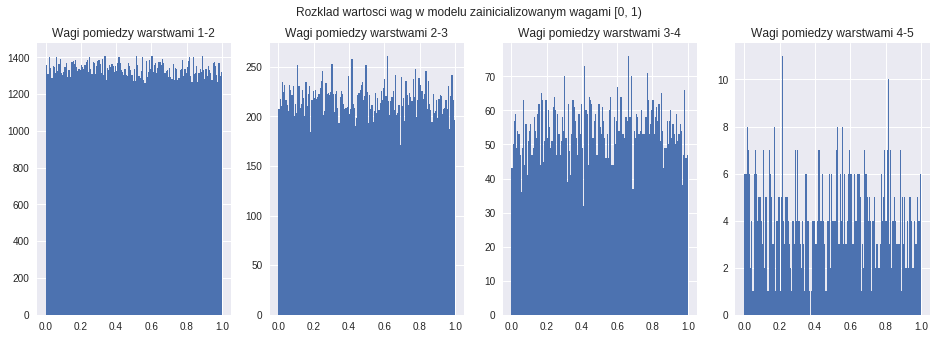

In [14]:
f, ax = plt.subplots(1, 4)
f.set_size_inches(16, 5)

f.suptitle("Rozklad wartosci wag w modelu zainicializowanym wagami [0, 1)")

model2_weights_0 = model2.layers[0].get_weights()[0].reshape(-1, 1)
ax[0].set_title("Wagi pomiedzy warstwami 1-2")
ax[0].hist(model2_weights_0, bins=150);

model2_weights_1 = model2.layers[1].get_weights()[0].reshape(-1, 1)
ax[1].set_title("Wagi pomiedzy warstwami 2-3")
ax[1].hist(model2_weights_1, bins=150);

model2_weights_2 = model2.layers[2].get_weights()[0].reshape(-1, 1)
ax[2].set_title("Wagi pomiedzy warstwami 3-4")
ax[2].hist(model2_weights_2, bins=150);

model2_weights_3 = model2.layers[3].get_weights()[0].reshape(-1, 1)
ax[3].set_title("Wagi pomiedzy warstwami 4-5")
ax[3].hist(model2_weights_3, bins=150);

#### Wniosek:
Wagi sieci neuronowej powinny być symetryczne względem zera.

Przetestujemy zakresy wartości [-0.001, 0.001), [-0.01, 0.01), [-0.1, 0.1).

In [0]:
# [-0.001, 0.001)
model4, history4, score4 = build_and_train_model(
    X_train_input, y_train_input, X_val_input, y_val_input, 
    initializer=RandomUniform(minval=-0.001, maxval=0.001, seed=RANDOM_SEED))

# [-0.01, 0.01)
model5, history5, score5 = build_and_train_model(
    X_train_input, y_train_input, X_val_input, y_val_input, 
    initializer=RandomUniform(minval=-0.01, maxval=0.01, seed=RANDOM_SEED))

# [-0.1, 0.1)
model6, history6, score6 = build_and_train_model(
    X_train_input, y_train_input, X_val_input, y_val_input, 
    initializer=RandomUniform(minval=-0.1, maxval=0.1, seed=RANDOM_SEED))

Inicializacja wag: [-0.001, 0.001):
 - error: 0.276421582599
 - acc: 0.918583333333

Inicializacja wag: [-0.01, 0.01):
 - error: 0.178217308713
 - acc: 0.948416666667

Inicializacja wag: [-0.1, 0.1):
 - error: 0.106428901855
 - acc: 0.968666666667


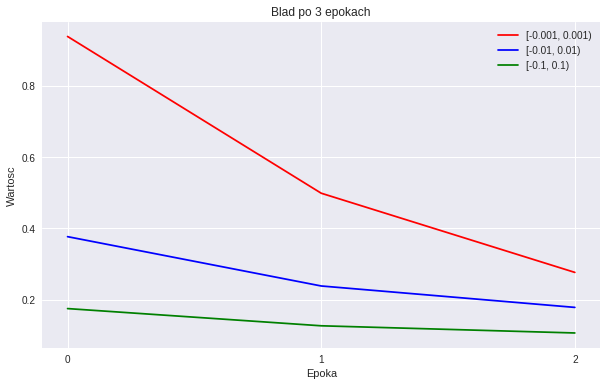

In [16]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)

ax.plot(history4.history["val_loss"], c="r")
ax.plot(history5.history["val_loss"], c="b")
ax.plot(history6.history["val_loss"], c="g")
ax.set_title("Blad po 3 epokach")
ax.set_ylabel("Wartosc")
ax.set_xlabel("Epoka")
ax.set_xticks([0, 1, 2])
ax.legend(["[-0.001, 0.001)", "[-0.01, 0.01)", "[-0.1, 0.1)"], loc="best");
    
test_score4, test_accuracy4 = score4
print("Inicializacja wag: [-0.001, 0.001):")
print(" - error: {}".format(test_score4))
print(" - acc: {}".format(test_accuracy4))

test_score5, test_accuracy5 = score5
print("\nInicializacja wag: [-0.01, 0.01):")
print(" - error: {}".format(test_score5))
print(" - acc: {}".format(test_accuracy5))

test_score6, test_accuracy6 = score6
print("\nInicializacja wag: [-0.1, 0.1):")
print(" - error: {}".format(test_score6))
print(" - acc: {}".format(test_accuracy6))

Tu widać, że zbyt małe wartości wag też nie są za dobre i sieć zaczyna radzić sobie coraz gorzej. Wynika to z tego, że jeżeli wagi są zbyt małe, to liczby na warstwie wyjściowej również są małe (mnożymy przez siebie cały czas małe wartości). Efektem tego jest nieznaczna zmiana wartości wag podczas fazy **backpropagation**.

#### Wniosek: 
Zbyt małe wagi sieci powodują, że sieć się gorzej uczy.

### Rozkład Normalny (RandomNormal)

W rozkładzie normalnym istnieje większe prawdopodobieństwo wylosowania liczby bliżej średniej całego rozkładu. W naszym wypadku chcemy by średnią było zero i by wartości wag oscylowały po jego obu stronach. O wielościach oscylacji decyduje odchylenie standardowe. 

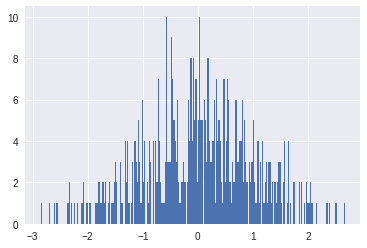

In [17]:
space1 = np.random.normal(0.0, 1.0, size=500)
n1, bins1, patches1 = plt.hist(space1, bins=250);

Wiemy, że dla Rozkładu Prostego najelpsze wyniki otrzymaliśmy dla wag z przedziału [-0.1, 0.1). Dlatego porównajmy teraz jak poradzi sobie sieć, gdy użyjemy Rozkładu Normalnego dla mean=0.0 i std=0.1.

In [0]:
model7, history7, score7 = build_and_train_model(
    X_train_input, y_train_input, X_val_input, y_val_input, 
    initializer=RandomNormal(mean=0.0, stddev=0.1, seed=RANDOM_SEED))


Inicializacja wag: Uniform [-0.1, 0.1):
 - error: 0.106428901855
 - acc: 0.968666666667

Inicializacja wag: Normal std=0.1
 - error: 0.115185060453
 - acc: 0.96625


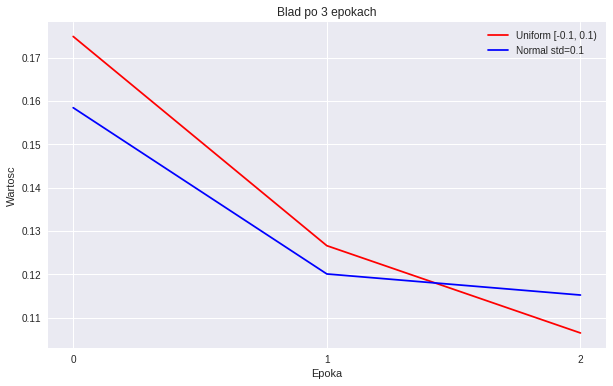

In [19]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)

ax.plot(history6.history["val_loss"], c="r")
ax.plot(history7.history["val_loss"], c="b")
ax.set_title("Blad po 3 epokach")
ax.set_ylabel("Wartosc")
ax.set_xlabel("Epoka")
ax.set_xticks([0, 1, 2])
ax.legend(["Uniform [-0.1, 0.1)", "Normal std=0.1"], loc="best");

test_score6, test_accuracy6 = score6
print("\nInicializacja wag: Uniform [-0.1, 0.1):")
print(" - error: {}".format(test_score6))
print(" - acc: {}".format(test_accuracy6))

test_score7, test_accuracy7 = score7
print("\nInicializacja wag: Normal std=0.1")
print(" - error: {}".format(test_score7))
print(" - acc: {}".format(test_accuracy7))

Wyniki są bardzo porównywalne. Prawdopodobnie przy wielu restartach sieci mogło by się okazać, że raz rozkład Prosty a raz Normalny daje lepszy wynik. Jest jeszcze jeden rozkład, który warto przetestować.

### Rozkład Przycięty Normalny (Truncated Normal) 

Jest to nadal rozkład normalny, ale losowane wartości nie mogą być większe niż dwukrotność odchylenia standardowego.

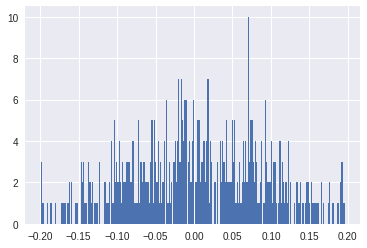

In [20]:
lower = -0.2
upper = 0.2
mean = 0.0
std= 0.1
N = 500

space3 = truncnorm.rvs(
    (lower - mean) / std, (upper - mean) / std, loc=mean, scale=std, size=N)

n3, bins3, patches3 = plt.hist(space3, bins=250);

In [0]:
model8, history8, score8 = build_and_train_model(
    X_train_input, y_train_input, X_val_input, y_val_input, 
    initializer=TruncatedNormal(mean=0.0, stddev=0.1, seed=RANDOM_SEED))


Inicializacja wag: Uniform [-0.1, 0.1):
 - error: 0.106428901855
 - acc: 0.968666666667

Inicializacja wag: Normal std=0.1
 - error: 0.115185060453
 - acc: 0.96625

Inicializacja wag: Truncated Normal std=0.1
 - error: 0.0851937202856
 - acc: 0.97225


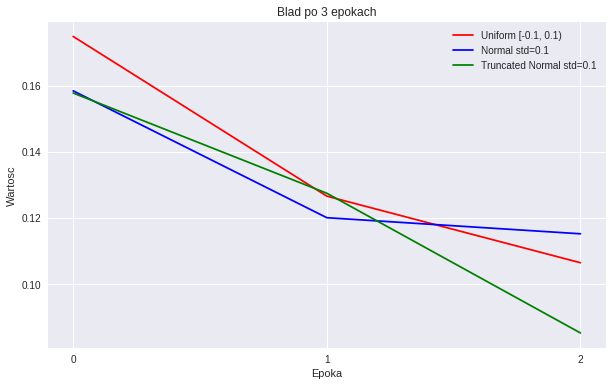

In [22]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)

ax.plot(history6.history["val_loss"], c="r")
ax.plot(history7.history["val_loss"], c="b")
ax.plot(history8.history["val_loss"], c="g")
ax.set_title("Blad po 3 epokach")
ax.set_ylabel("Wartosc")
ax.set_xlabel("Epoka")
ax.set_xticks([0, 1, 2])
ax.legend(["Uniform [-0.1, 0.1)", "Normal std=0.1", 
           "Truncated Normal std=0.1"], loc="best");

test_score6, test_accuracy6 = score6
print("\nInicializacja wag: Uniform [-0.1, 0.1):")
print(" - error: {}".format(test_score6))
print(" - acc: {}".format(test_accuracy6))

test_score7, test_accuracy7 = score7
print("\nInicializacja wag: Normal std=0.1")
print(" - error: {}".format(test_score7))
print(" - acc: {}".format(test_accuracy7))

test_score8, test_accuracy8 = score8
print("\nInicializacja wag: Truncated Normal std=0.1")
print(" - error: {}".format(test_score8))
print(" - acc: {}".format(test_accuracy8))

### Inicializacja Xaviera

Jedną z najczęściej używanych inicializacji wag siecie neuronowej jest tak zwana Inicializacja Xaviera, czasami nazywana też Inicializacją Glorota (jako, że Xavier miał na nazwisko Glorot).

W opublikowanym papierze naukowym Xavier Glorot i Yoshua Bengio propnują metode inicializacji wag, która zostaje przyjęta:

http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

Jej główną zaletą jest to, że wartość początkowa wag jest zależna od neuronów poprzedniej oraz następnej warstwy. Na bazie tych rozmiarów, dokonywane jest skalowanie wag w taki sposób, by po całej fazie **feedworward** wystarczająco duże wartości znalazły się na wyjściu sieci neuronowej. Dzięki temu podczas fazy **backpropagation** odpowiednio duże wartości są rozprowadzane po sieci a tym samym aktualizowane wagi. 

Wzór:

$$W_i = \text{random_uniform}(\frac{-1}{\sqrt{n_i}}, \frac{1}{\sqrt{n_{i+1}}})$$

gdzie:
- i - indeks warstwy
- W - macierz wag
- n - ilość neuronów w warstwie

Czasami zamiast `1` w mianownikach używa się `2`. 


In [0]:
model9, history9, score9 = build_and_train_model(
    X_train_input, y_train_input, X_val_input, y_val_input, 
    initializer=glorot_uniform()) 

In [24]:
test_score9, test_accuracy9 = score9
print("Inicializacja wag: Xavier")
print(" - error: {}".format(test_score9))
print(" - acc: {}".format(test_accuracy9))

Inicializacja wag: Xavier
 - error: 0.0937001416938
 - acc: 0.97175


### Podsumowanie

In [25]:
print("Wyniki: ")

table = [
         ["Init", "Loss", "Accuracy"],
         ["Zeros", test_score0, test_accuracy0],
         ["Ones", test_score1, test_accuracy1],
         ["[0.0, 1.0)", test_score2, test_accuracy2],
         ["[-1.0, 1.0)", test_score3, test_accuracy3],
         ["[-0.001, 0.001)", test_score4, test_accuracy4],
         ["[-0.01, 0.01)", test_score5, test_accuracy5],
         ["[-0.1, 0.1)", test_score6, test_accuracy6],
         ["Normal std=0.1", test_score7, test_accuracy7],
         ["Truncated std=0.1", test_score8, test_accuracy8],
         ["Xavier/Glorot", test_score9, test_accuracy9]
        ]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Wyniki: 


Init,Loss,Accuracy
Zeros,2.302091397603353,0.106
Ones,14.449872375488281,0.1035
"[0.0, 1.0)",14.409577087402344,0.106
"[-1.0, 1.0)",7.070488763809204,0.5605833333333333
"[-0.001, 0.001)",0.27642158259948096,0.9185833333333333
"[-0.01, 0.01)",0.17821730871250233,0.9484166666666667
"[-0.1, 0.1)",0.10642890185521295,0.9686666666666667
Normal std=0.1,0.1151850604529803,0.96625
Truncated std=0.1,0.08519372028562551,0.97225
Xavier/Glorot,0.09370014169377586,0.97175


1. Inicializacja wag sieci neuronowej jest BARDZO istotna. Drastycznie wpływa na wyniki i to jak sieć jest w stanie się uczyć. 
2. Nie ma jednego przepisu, w jaki sposób powinno się to robić. Istnieje wiele metod - takich jak Inicializacja Xaviera, które mają poparcie naukowe i ogólnie działają.
3. Każdy problem jest inny. Początkowo warto skorzystać z metod sprawdzonych a dopiero potem próbować eksperymentować, jeżeli bardzo nam zależy nad poprawieniem jakości modelu.
4. Nie można ostatecznie stwierdzić, że korzystanie z rozkładu Prostego (RandomUniform) jest zdecydowanie lepsze niż Normalnego (RandomNormal, TruncatedNormal). Wiele osób twierdzi, że TruncatedNormal radzi sobie lepiej od pozostałych, jeżeli mamy do czynienia z głębokimi sieciami neuronowymi.